## Data Collection

Main data collection is done by running ['update.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/update.py) on a Flask ['server.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/server.py) scheduled through ngrok and Invictify. You can find the construction of functions used in this notebook in ['youtube_api_functions.py](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/youtube_api_functions.py), ['MySQL_DB_connect_functions.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/MySQL_DB_connect_functions.py), and ['MySQL_DB_update_functions.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/MySQL_DB_update_functions.py).

This data collection pipeline automatically updates the AWS MySQL RDS database with up-to-date channel statistics depending on the configured Invictify schedule.

In [2]:
from MySQL_DB_connect_functions import *
from MySQL_DB_update_functions import *
from youtube_api_functions import *

This project will analyze a selection of news channels on Youtube, since they produce a large number of videos covering a variety of topics.

In [3]:
channel_id_list = ['UCIRYBXDze5krPDzAEOxFGVA'] #TheGuardian
channel_id_list = ['UCqnbDFdCpuN8CMEg0VuEBqA'] #NYTimes
channel_id_list = ['UCBi2mrWuNuyYy4gbM6fU18Q'] #ABCNews
channel_id_list = ['UCeY0bbntWzzVIaj2z3QigXg'] #NBCNews
channel_id_list = ['UCaXkIU1QidjPwiAYu6GcHjg'] #MSNBC

In [4]:
# Create Youtube Data API object & cleaned dataframe containing video data from selected channel using function from youtube_api_functions.py:
youtube_obj = build_yt_API_object() # builds Youtube API object

Data uploaded to the MySQL database can be pulled by uncommenting the code cell below. Rest of the analysis uses direct usage of the Youtube Data API functions for dynamic analysis of multiple channels.

In [5]:
# host_name, dbname, schema_name, port, username, password = get_db_info() # imports sensitive auth. information from .env file
# cnx = connect_to_db(username, password, host_name, schema_name, port) # creates connection object
# cursor = cnx.cursor() # activates connection cursor
# video_df = return_df_from_db('videos', cursor)

Directly using the Youtube Data API:

In [6]:
video_df = create_video_df(youtube_obj, channel_id_list, 500) # store API data into pandas df
processed_video_df = clean_video_df(video_df) # run df through cleaning function

In [7]:
selected_df = processed_video_df.query('viewCount > 5000 & commentCount > 500')

In [8]:
video_ids = list(selected_df['video_id'])

## Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

#### Does the number of likes and comments matter for a video to get more views?
It can be observed that the number of views and number of comments/ likes strongly correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. 

<Figure size 1008x504 with 0 Axes>

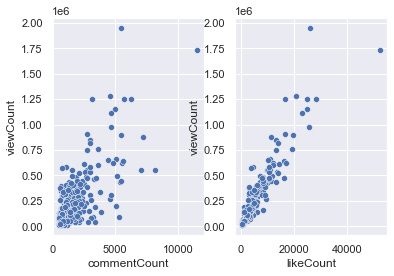

<Figure size 1008x504 with 0 Axes>

In [10]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = selected_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = selected_df, x = "likeCount", y = "viewCount", ax=ax[1])
plt.figure(figsize = (14,7))

#### Does the video duration matter for views and interaction (likes/comments)?
It can be seen in the histogram below, most videos are between 100 to 800 seconds, which is about 1.6 to 13 minutes. The duration has been limited to 10,000 to prevent extremely long videos (live streams, for example).

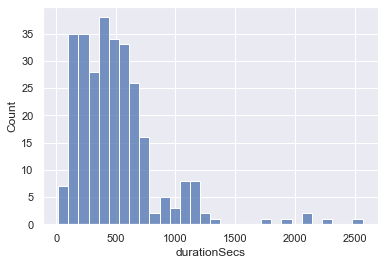

In [11]:
sns.histplot(data=selected_df[selected_df['durationSecs'] < 10000], x="durationSecs", bins=30)

Plotting the duration against comment count and like count, it can be seen that shorter videos tend to get more likes and comments than very long videos.

<Figure size 1008x504 with 0 Axes>

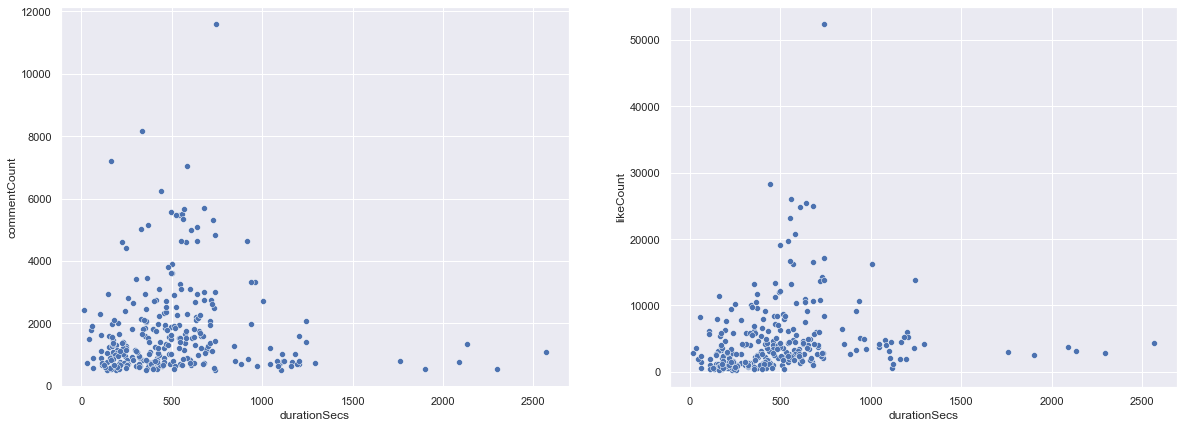

<Figure size 1008x504 with 0 Axes>

In [12]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = selected_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = selected_df, x = "durationSecs", y = "likeCount", ax=ax[1])
plt.figure(figsize = (14,7))

#### Which day in the week are most videos uploaded?
It's interesting to see that most videos are posted Tuesday and Saturday. Fewer videos are posted on Mondays and Sundays. This could be because of the nature of news channels, where most of the event coverage happens during the weekdays. But it could also mean that most of the workers produce the most output and coverage during typical working days.

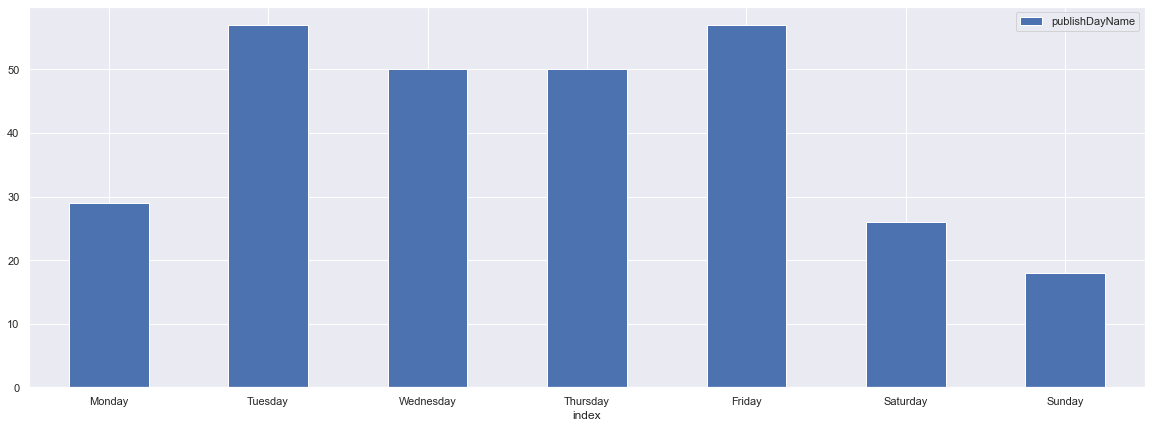

In [13]:
day_df = pd.DataFrame(selected_df['publishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0)

## VADER NLP

### Comment Extraction & Data Cleaning

In [14]:
all_comments_df = pd.DataFrame()
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    all_comments_df = all_comments_df.append(comment_data, ignore_index=True)

In [15]:
all_comments_df.head()

,video_id,comment_id,comment,date
0,am_gdcDMCMU,UgzQtc2Qf0g6jMHrXuJ4AaABAg,My man,2022-09-24T02:01:03Z
1,am_gdcDMCMU,UgzherIZEiXzTRbMylp4AaABAg,DeSatan deserves a lot more than a lawsuit.,2022-09-24T01:57:47Z
2,am_gdcDMCMU,UgzxNKZ-7hAI4PtkGVx4AaABAg,"I hope you win, desantis seems to think he is ...",2022-09-24T01:56:13Z
3,am_gdcDMCMU,Ugw1O1yILxFahs0eFLt4AaABAg,Desantis should be in PRISON!!! GO ANDREW!!!,2022-09-24T01:56:08Z
4,am_gdcDMCMU,UgyKmSQbQz_5mh2A_y14AaABAg,Truth Well Stated⚖️,2022-09-24T01:55:53Z


In [16]:
def preprocess(comment):
    comment = comment.str.replace("\n", " ") # remove new lines 
    return comment

all_comments_df['comment'] = preprocess(all_comments_df['comment'])

### Sentiment Analysis (VADER Model)
By analyzing the sentiment in each video's comment thread, we assign the video its degree of polarity - or how provocative it is.

In [17]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [18]:
all_comments_df['vader_sentiment'] = all_comments_df.comment.apply(lambda x: sia.polarity_scores(x))
all_comments_df['vader_comp_sentiment'] = all_comments_df.vader_sentiment.apply(lambda x: x['compound'])

In [19]:
video_comp_sentiments = pd.DataFrame(columns=['video_id', 'vid_title', 'avg_comp_sentiment', 'vid_viewcount'])
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    comment_data['vader_sentiment'] = comment_data.comment.apply(lambda x: sia.polarity_scores(x))
    comment_data['vader_comp_sentiment'] = comment_data.vader_sentiment.apply(lambda x: x['compound'])
    comp_mean = comment_data['vader_comp_sentiment'].mean()

    vid_title = processed_video_df.loc[processed_video_df['video_id'] == video, 'title'].item()
    vid_viewcount = processed_video_df.loc[processed_video_df['video_id'] == video, 'viewCount'].item()
    vid_likecount = processed_video_df.loc[processed_video_df['video_id'] == video, 'likeCount'].item()

    dict = {'video_id': video,
            'vid_title': vid_title,
            'avg_comp_sentiment': comp_mean,
            'vid_viewcount': vid_viewcount,
            'vid_likecount': vid_likecount
            }

    video_comp_sentiments = video_comp_sentiments.append(dict, ignore_index=True)
    

In [20]:
video_comp_sentiments

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,am_gdcDMCMU,FL State Attorney On Taking DeSantis To Trial ...,0.060104,54703,2291.0
1,iKyrUE2XWDU,Michael Cohen Thinks Criminal Prosecutions Are...,0.017997,145322,6078.0
2,TNfhkx1Kv20,Committee Will Lay Out More On Trump’s Culpabi...,-0.075079,65561,2160.0
3,r24Xn81kD3w,Gaetz Unlikely To Be Charged In Sex Crimes Probe,-0.086063,26671,572.0
4,X3RiD7E1h0s,FBI 'Planted' Evidence? Trump Has Until Sept. ...,0.023173,257924,5378.0
...,...,...,...,...,...
282,V2o6H4pzuZM,ADL Finds Hundreds Of Law Enforcement Officers...,-0.042841,57037,1415.0
283,ypV5-GXoNRI,The Future Of Abortion Rights In Michigan Will...,0.001163,108642,2412.0
284,LlRR7F9D9v0,President Biden Accepts Invitation To Attend Q...,0.005188,143668,1257.0
285,d-T2CRu5z2U,The U.S. Faces A New Type Of Threat 21 Years A...,-0.308206,50171,1174.0


### Sentiment Analysis Data Visualization (Plotly)

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

Find the interactive graph [here](https://cjunwon.github.io/Youtube-Data-Analysis/).

Prior to analysis, I predicted that the plotted view count graph would display a 'U' shape, where videos with more provocative videos (bad and good) getting more views. I also predicted that the like count plots would show a linear pattern, with more positive videos showing more like counts.

However, both the view and like count plots are closer to a normal distribution. This could be explained by the fact that a user's choice in liking a video is determined by various factors (not just the emotions charged through the video) and differ amongst individuals.

Hovering over the interactive graph, it can be seen that videos with more extreme sentiment scores have view and like counts much closer than those with more neutral scores. This shows that a greater ratio of these videos' viewers like the video. One assumption we can make is that videos that generate more extreme sentiments have more viewers in agreement with the video's content.

In [22]:
from re import template


fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score",
    template='plotly_dark'
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='vscode')

pio.write_html(fig, file='index.html', auto_open=True)

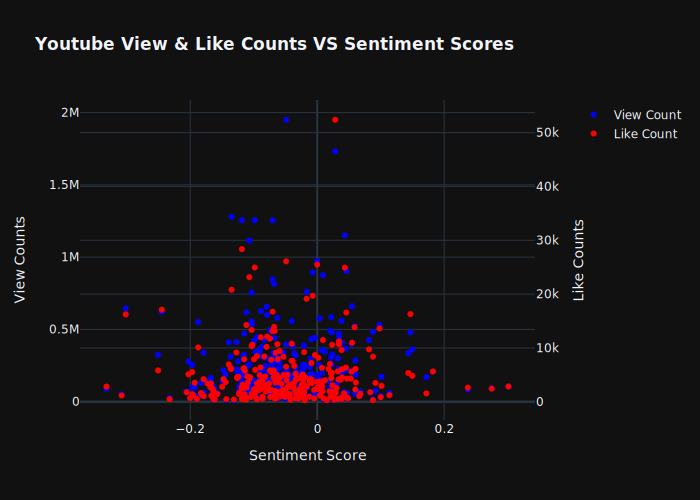

In [23]:
from re import template


fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score",
    template='plotly_dark',
    autosize=True
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='svg')

# pio.write_html(fig, file='index.html', auto_open=True)

Below is a bubble chart with bubble size and color set as a scaled composite sentiment score per video. Initial sentiment scores ranged from -1 to 1, but they were scaled to all be positive values to plot as a bubble chart.

In [24]:
scaled_sentiment_df = video_comp_sentiments.copy()
scaled_sentiment_df['avg_comp_sentiment'] = np.where(scaled_sentiment_df['avg_comp_sentiment'] > 0, scaled_sentiment_df['avg_comp_sentiment'] * 2, scaled_sentiment_df['avg_comp_sentiment'])
scaled_sentiment_df['avg_comp_sentiment'] = np.where(scaled_sentiment_df['avg_comp_sentiment'] < 0, scaled_sentiment_df['avg_comp_sentiment'] * -1, scaled_sentiment_df['avg_comp_sentiment'])

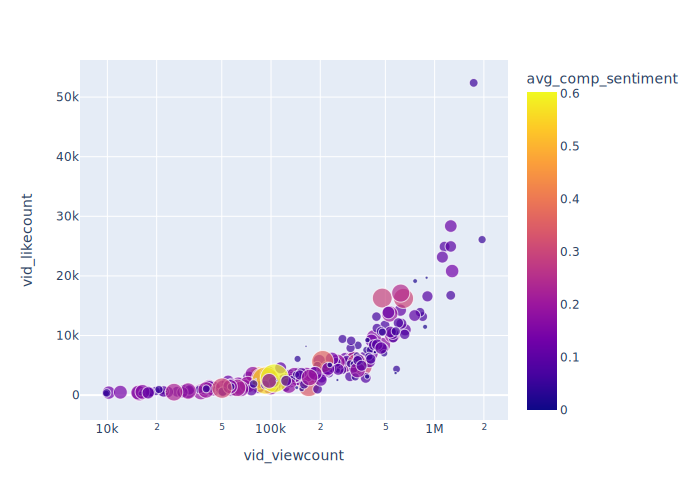

In [26]:
import plotly.express as px

fig = px.scatter(scaled_sentiment_df, x="vid_viewcount", y="vid_likecount",
	         size="avg_comp_sentiment",
             color="avg_comp_sentiment", hover_name="vid_title", log_x=True)
fig.show(renderer='svg')